# Carbon Footprint Eval

In [1]:
import pandas as pd
import gzip
import json
from tqdm import tqdm
from statistics import mean
import os

RETRIEVAL_PARADIGMS = {
    'multi-qa-distilbert-cos-v1': 'Bi-Encoder',
    'DPH': 'Lexical',
    'multi-qa-minilm-l6-cos-v1': 'Bi-Encoder',
    'IFB2': 'Lexical',
    'InB2': 'Lexical',
    'msmarco-minilm-l12-cos-v5': 'Bi-Encoder',
    'PL2': 'Lexical',
    'BM25': 'Lexical',
    'hltcoe-plaidx-large-eng-tdist-mt5xxl-engeng': 'Late Interaction',
    'DirichletLM': 'Lexical',
    'colbert-ir-colbertv2.0': 'Late Interaction',
    'multi-qa-mpnet-base-cos-v1': 'Bi-Encoder',
    'sentence-transformers-msmarco-roberta-base-ance-firstp': 'Bi-Encoder',
    'TF_IDF': 'Lexical',
    'DFIZ': 'Lexical',
    'msmarco-minilm-l6-cos-v5': 'Bi-Encoder',
    'DLH': 'Lexical',
    'msmarco-distilbert-base-tas-b': 'Bi-Encoder',
    'colbert-ir-colbertv1.9': 'Late Interaction',
    'Hiemstra_LM': 'Lexical',
    'msmarco-distilbert-base-v3': 'Bi-Encoder',
}

def dataset_id_to_corpus_sizes():
    if not os.path.isfile('../data/processed/carbon-footprints/dataset-sizes.json'):
        
        ret = {}
        for dataset in tqdm(["msmarco-passage/trec-dl-2019/judged", "msmarco-passage/trec-dl-2020/judged", "disks45/nocr/trec-robust-2004", "clueweb09/en/trec-web-2012", "clueweb12/trec-web-2014"]):
            ret[dataset] = {}
            with gzip.open(f'../data/processed/sampled-corpora/{dataset.replace("/", "-")}.json.gz') as f:
                f = json.load(f)
                for group in f.keys():
                    for sampling in f[group].keys():
                        if sampling not in ret[dataset]:
                            ret[dataset][sampling] = set()

                        ret[dataset][sampling].update(f[group][sampling])
                
                ret[dataset] = {k: len(v) for k, v in ret[dataset].items()}
        
        json.dump(ret, open('../data/processed/carbon-footprints/dataset-sizes.json', 'w'))

    return json.load(open('../data/processed/carbon-footprints/dataset-sizes.json'))

def to_rows(df):
    ret = []
    for sampling in df.keys():
        row = {'Sampling': sampling}
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                row[f'{paradigm} ({dataset})'] = mean(df[sampling][paradigm][dataset])
        ret += [row]
    return pd.DataFrame(ret)

def parse_data(file_name, target_maeasure):
    raw_data = pd.read_json(file_name, lines=True)
    df = {}
    for _, i in raw_data.iterrows():
        if i['sampling'] not in df:
            df[i['sampling']] = {}
        paradigm = RETRIEVAL_PARADIGMS[i['approach']]
        if paradigm not in df[i['sampling']]:
            df[i['sampling']][paradigm] = {}
        dataset = i['dataset'].split('/')[0]

        if dataset not in df[i['sampling']][paradigm]:
            df[i['sampling']][paradigm][dataset] = []
        df[i['sampling']][paradigm][dataset] += [target_maeasure(i)]

    return df


In [2]:
df_recall = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: i['Recall@10'])
df_recall = to_rows(df_recall)
df_recall

,Sampling,Bi-Encoder (disks45),Bi-Encoder (msmarco-passage),Bi-Encoder (clueweb12),Lexical (disks45),Lexical (msmarco-passage),Lexical (clueweb12),Late Interaction (disks45),Late Interaction (msmarco-passage),Late Interaction (clueweb12)
0,loft-10000,0.36340,0.691860,0.17925,0.460693,0.557623,0.3098,0.431867,0.705534,0.163333
1,top-50-run-pool,0.85235,0.955539,0.50900,0.932600,0.910835,0.7556,0.782533,0.821483,0.452000
2,top-100-run-pool,0.91355,0.971035,0.61475,0.948840,0.932194,0.8006,0.792800,0.833807,0.550667
3,re-rank-top-1000-bm25,0.89625,0.849841,0.15925,0.962560,0.858301,0.1134,0.785867,0.783563,0.171333
4,top-1000-run-pool,1.00000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
5,top-25-run-pool,0.77130,0.924516,0.40050,0.915600,0.892524,0.6856,0.750400,0.811671,0.358667
6,loft-1000,0.08750,0.602713,0.10875,0.119573,0.483320,0.1788,0.108267,0.638257,0.089333
7,top-10-run-pool,0.64080,0.848030,0.27650,0.889320,0.864783,0.5832,0.686533,0.796885,0.254000


In [3]:
df_rbo = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: i['RBO@10'])
df_rbo = to_rows(df_rbo)
df_rbo

,Sampling,Bi-Encoder (disks45),Bi-Encoder (msmarco-passage),Bi-Encoder (clueweb12),Lexical (disks45),Lexical (msmarco-passage),Lexical (clueweb12),Late Interaction (disks45),Late Interaction (msmarco-passage),Late Interaction (clueweb12)
0,loft-10000,0.430582,0.777053,0.185346,0.495037,0.601252,0.308489,0.458698,0.693105,0.167264
1,top-50-run-pool,0.887663,0.973044,0.506315,0.927468,0.914035,0.751647,0.754578,0.781281,0.440173
2,top-100-run-pool,0.935529,0.981414,0.612950,0.945832,0.932849,0.792483,0.759429,0.787356,0.524347
3,re-rank-top-1000-bm25,0.921333,0.889630,0.145858,0.962761,0.857591,0.083687,0.758209,0.748777,0.159421
4,top-1000-run-pool,0.999502,1.000000,0.990472,0.999940,0.999464,0.989666,0.995125,0.993912,0.977158
5,top-25-run-pool,0.823750,0.953659,0.407372,0.910377,0.901202,0.686493,0.726156,0.760663,0.358181
6,loft-1000,0.113500,0.679517,0.115047,0.138048,0.513223,0.176002,0.129621,0.634065,0.102887
7,top-10-run-pool,0.712071,0.907697,0.288946,0.884708,0.879630,0.605947,0.681891,0.755529,0.255754


In [4]:
dataset_sizes = dataset_id_to_corpus_sizes()
EMISSION_FIELD = 'energy_consumed'

def to_emission_rows(df):
    ret = []
    for sampling in df.keys():
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                for tmp in df[sampling][paradigm][dataset]:
                    ret += [{'Paradigm': paradigm, 'Size': tmp['Size'], 'Emissions': tmp['Emissions'],'Dataset': dataset}]
    return pd.DataFrame(ret)

In [5]:
df_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated'][EMISSION_FIELD], 'Size': dataset_sizes[i['dataset']][i['sampling']]})

df_emissions = to_emission_rows(df_emissions)

In [6]:
CORPUS_SIZES = {
    'clueweb09': 1040859705,
    'clueweb12': 733019372,
    'msmarco-passage': 8841823,
    'disks45': 528155
}

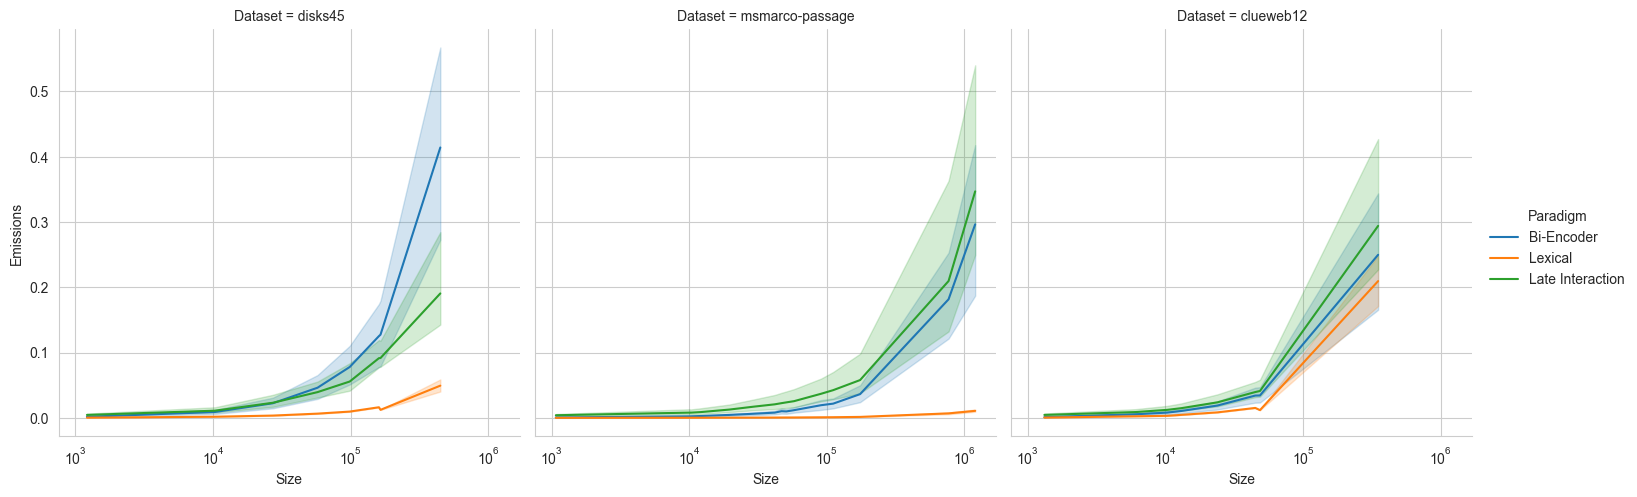

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df_emissions, kind='line', x='Size', y='Emissions', col='Dataset', hue='Paradigm')
plt.xscale('log')

In [8]:
observed_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated'][EMISSION_FIELD], 'Size': dataset_sizes[i['dataset']][i['sampling']]})

In [9]:
aggregated_observed_emissions = {}

for dataset_type in observed_emissions.keys():
    for paradigm in observed_emissions[dataset_type].keys():
        for dataset in observed_emissions[dataset_type][paradigm].keys():
            if paradigm not in aggregated_observed_emissions:
                aggregated_observed_emissions[paradigm] = {}
            if dataset not in aggregated_observed_emissions[paradigm]:
                aggregated_observed_emissions[paradigm][dataset] = {'Emissions': 0, 'Size': 0}
            for i in observed_emissions[dataset_type][paradigm][dataset]:
                aggregated_observed_emissions[paradigm][dataset]['Emissions'] += i['Emissions']
                aggregated_observed_emissions[paradigm][dataset]['Size'] += i['Size']
                aggregated_observed_emissions[paradigm][dataset]['EmissionsPerDocument'] = aggregated_observed_emissions[paradigm][dataset]['Emissions'] / aggregated_observed_emissions[paradigm][dataset]['Size']


In [10]:
MAX_SIZES = {i['Dataset']: i['Size'] for _, i in df_emissions[['Size', 'Dataset']].groupby('Dataset').agg({'Size': 'max'}).reset_index().iterrows()}
MAX_SIZES

{'clueweb12': 351830, 'disks45': 449371, 'msmarco-passage': 1199244}

In [11]:
df_predicted_observations = []

for i in [100000, 1000000, 10000000, 100000000, 1000000000]:
    for dataset in ['disks45', 'msmarco-passage', 'clueweb12']:
        size = max(MAX_SIZES[dataset], i)
        for paradigm in ['Bi-Encoder', 'Lexical', 'Late Interaction']:
            size = min(size, CORPUS_SIZES[dataset])
            emissions = size*aggregated_observed_emissions[paradigm][dataset]['EmissionsPerDocument']
            df_predicted_observations += [{'Paradigm': paradigm + ' (Predicted)', 'Size': size, 'Emissions': emissions, 'Dataset': dataset}]

df_predicted_observations = pd.DataFrame(df_predicted_observations)

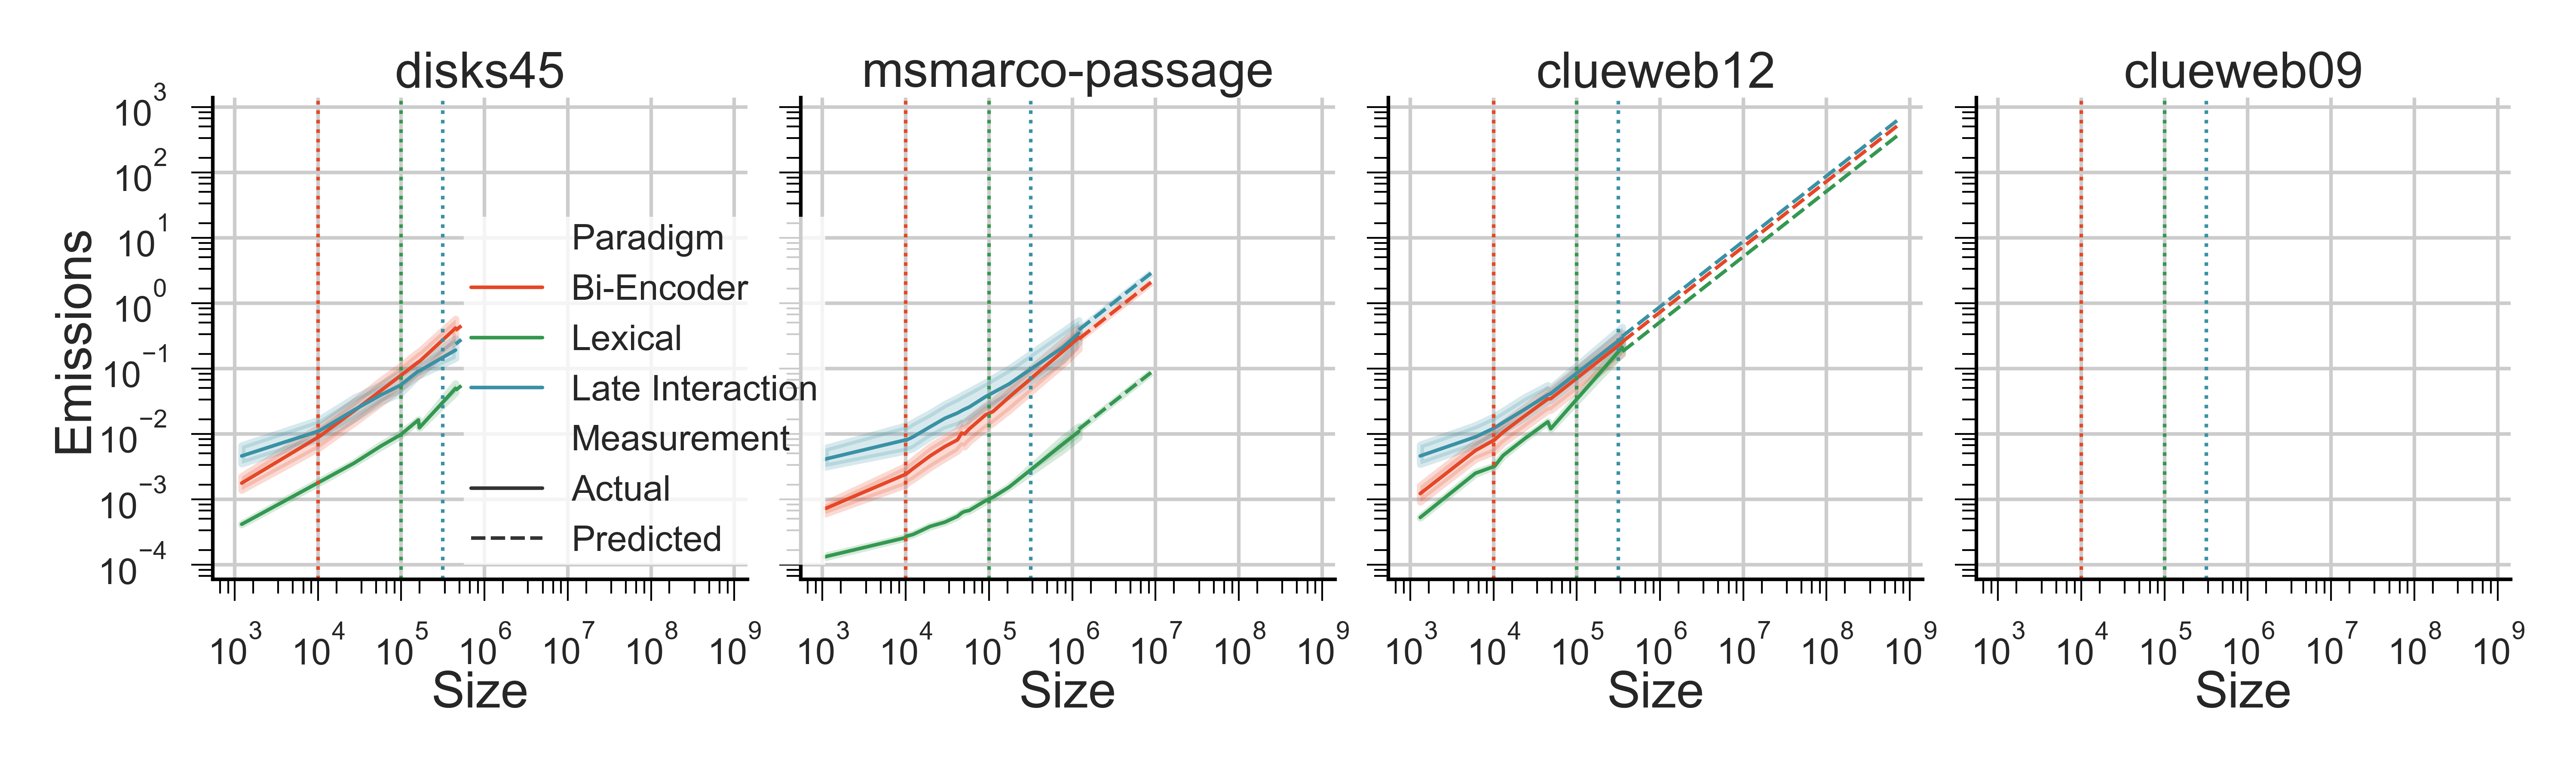

In [226]:
import matplotlib
import numpy as np
import matplotlib.ticker as ticker

# Add the recommended values here:
recommended_values = [
    [10**4, 10**5, 10**5.5],
    [10**4, 10**5, 10**5.5],
    [10**4, 10**5, 10**5.5],
    [10**4, 10**5, 10**5.5],
]

colwidth_pt = 347.12354
dpi = 1200
colwidth_inches = colwidth_pt / 72.27

tex_fonts = {
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 5,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5
}

palette = ["#E64727", "#349850", "#3A91A5"]

# ClueWeb09 is still running, extracting the corpus still needs 2 days to finish
# Hence, I add a pseudo entry so that we get the column at least
df_clueweb09 = pd.DataFrame([{'Paradigm': paradigm + ' (Predicted)', 'Size': size, 'Emissions': emissions, 'Dataset': 'clueweb09'}])
df_concat = pd.concat([df_emissions, df_predicted_observations, df_clueweb09]).rename(columns={"Paradigm": "ZZZ"}).assign(
    Paradigm=lambda x: np.select(
        [
            x['ZZZ'].str.startswith('Bi-Encoder'),
            x['ZZZ'].str.startswith('Lexical'),
            x['ZZZ'].str.startswith('Late Interaction')
        ],
        ['Bi-Encoder', 'Lexical', 'Late Interaction'],
        default='black'  # default color if none of the conditions match
    ),    
    Measurement=lambda x: np.where(x['ZZZ'].str.endswith('(Predicted)'), 'Predicted', 'Actual')
)
sns.set()
sns.set_theme(style="whitegrid", rc={"figure.dpi": dpi, "grid.linewidth": 0.5,"xtick.bottom" : True, "ytick.left" : True, "legend.frameon": True, "legend.fancybox": False, "legend.borderpad": 0.2, "legend.edgecolor": "white", "legend.framealpha": 0.8, "lines.linewidth": 0.5, "axes.edgecolor": "black", "axes.titlepad": 0.1})
plt.rcParams.update(tex_fonts)
g = sns.relplot(data=df_concat, kind='line', x='Size', y='Emissions', col='Dataset', hue='Paradigm', style='Measurement', palette=palette)
sns.despine(top=True, right=True)
g.fig.set_size_inches((colwidth_inches, 1.3))
g.set_titles("{col_name}")  # use this argument literally
for i, ax in enumerate(g.axes.flat):
    for j, v in enumerate(recommended_values[i]):
        ax.axvline(v, color=palette[j], linestyle="dotted")
    ax.linewidth=0.1
    ax.tick_params(axis="both", direction="out", which="both", left=True, bottom=True, color="black")
    ax.xaxis.set_tick_params(width=0.25, which="both")
    ax.xaxis.set_tick_params(which="major", length=3)
    ax.xaxis.set_tick_params(which="minor", length=2)
    ax.yaxis.set_tick_params(width=0.25, which="both")
    ax.yaxis.set_tick_params(which="major", length=3)
    ax.yaxis.set_tick_params(which="minor", length=2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=1000))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=1000))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.linspace(0, 1.0, 5 + 2)[1:-1], numticks=1000))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.linspace(0, 1.0, 5 + 2)[1:-1], numticks=1000))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    plt.setp(ax.spines.values(), linewidth=0.5)
    ax.xaxis.labelpad = 0
g.axes.flat[0].yaxis.labelpad = 0
leg = g._legend
leg.set_bbox_to_anchor([0.18, 0.85])
leg._loc = 2  # if required you can set the loc
leg.get_frame().set_linewidth(0)
leg.draw_frame(True)
plt.tight_layout(pad=0.05)
plt.subplots_adjust(wspace=0.1) 
plt.savefig(f'utilization-size-tradeoff.pdf', pad_inches=0)
plt.show()

In [82]:
df_concat

# add a new column called hue.
# If "Paradigm column starts with "Bi-Encoder", make the hue row red
# Otherwise make it green.


,Paradigm,Size,Emissions,Dataset,ParadigmColor,Measurement
0,Bi-Encoder,10331,0.008810,disks45,Bi-Encoder,Actual
1,Bi-Encoder,10331,0.004384,disks45,Bi-Encoder,Actual
2,Bi-Encoder,10331,0.005593,disks45,Bi-Encoder,Actual
3,Bi-Encoder,10331,0.016691,disks45,Bi-Encoder,Actual
4,Bi-Encoder,10331,0.016022,disks45,Bi-Encoder,Actual
...,...,...,...,...,...,...
41,Late Interaction (Predicted),8841823,2.861704,msmarco-passage,Late Interaction,Predicted
42,Bi-Encoder (Predicted),733019372,531.626093,clueweb12,Bi-Encoder,Predicted
43,Lexical (Predicted),733019372,375.261933,clueweb12,Lexical,Predicted
44,Late Interaction (Predicted),733019372,644.036284,clueweb12,Late Interaction,Predicted
